##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bayesian Neural Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/nn/examples/bnn_mnist_advi.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/nn/examples/bnn_mnist_advi.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### 1  Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

# Globally Enable XLA.
# tf.config.optimizer.set_jit(True)

try:
  physical_devices = tf.config.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

tfb = tfp.bijectors
tfd = tfp.distributions
tfn = tfp.experimental.nn

### 2  Load Dataset

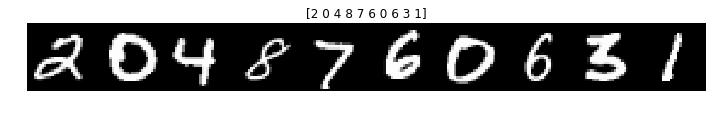

In [0]:
[train_dataset, eval_dataset], datasets_info = tfds.load(
    name='mnist',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True)

def _preprocess(image, label):
  image = tf.cast(image, dtype=tf.float32) / 255.
  label = tf.cast(label, dtype=tf.int32)
  return image, label

train_size = datasets_info.splits['train'].num_examples
batch_size = 32

train_dataset = tfn.util.tune_dataset(
    train_dataset,
    batch_size=batch_size,
    shuffle_size=int(train_size  / 7),
    preprocess_fn=_preprocess)

eval_dataset = tfn.util.tune_dataset(
    eval_dataset,
    repeat_count=None,
    preprocess_fn=_preprocess)

x, y = next(iter(eval_dataset.batch(10)))
tfn.util.display_imgs(x, y);

### 3  Define Model

In [0]:
max_pool = tf.keras.layers.MaxPooling2D(  # Has no tf.Variables.
    pool_size=(2, 2),
    strides=(2, 2),
    padding='SAME',
    data_format='channels_last')

bnn = tfn.Sequential([
  tfn.ConvolutionVariationalFlipout(
      input_size=1,
      output_size=8,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      penalty_weight=1. / train_size,
      name='conv1'),
  tf.nn.leaky_relu,
  max_pool,  # [28, 28, 8] -> [14, 14, 8]
  tfn.ConvolutionVariationalFlipout(
      input_size=8,
      output_size=16,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      penalty_weight = 1. / train_size,
      name='conv2'),
  tf.nn.leaky_relu,
  max_pool,  # [14, 14, 16] -> [7, 7, 16]
  tfn.util.flatten_rightmost(ndims=3),
  tfn.AffineVariationalReparameterizationLocal(
      input_size=7 * 7 * 16,
      output_size=10,
      penalty_weight = 1. / train_size,
      name='affine1'),
  lambda x: tfd.Categorical(logits=x, dtype=tf.int32),   
], name='BNN')

print(bnn.summary())

=== BNN ==================================================
  SIZE SHAPE                TRAIN NAME                                    
   200 [5, 5, 1, 8]         True  posterior_kernel_loc:0                  
   200 [5, 5, 1, 8]         True  posterior_kernel_scale:0                
     8 [8]                  True  posterior_bias_loc:0                    
     8 [8]                  True  posterior_bias_scale:0                  
  3200 [5, 5, 8, 16]        True  posterior_kernel_loc:0                  
  3200 [5, 5, 8, 16]        True  posterior_kernel_scale:0                
    16 [16]                 True  posterior_bias_loc:0                    
    16 [16]                 True  posterior_bias_scale:0                  
  7840 [784, 10]            True  posterior_kernel_loc:0                  
  7840 [784, 10]            True  posterior_kernel_scale:0                
    10 [10]                 True  posterior_bias_loc:0                    
    10 [10]                 True  posteri

### 4  Train

In [0]:
train_iter = iter(train_dataset)
eval_iter = iter(eval_dataset.batch(2000).repeat())

def loss():
  x, y = next(train_iter)
  nll = -tf.reduce_mean(bnn(x).log_prob(y), axis=-1)
  kl = bnn.extra_loss
  return nll + kl, (nll, kl)

opt = tf.optimizers.Adam(learning_rate=1e-2)

_DEBUG = False
 
fit = tfn.util.make_fit_op(
    loss,
    opt,
    bnn.trainable_variables,
    grad_summary_fn=lambda gs: tf.nest.map_structure(tf.norm, gs),
    tf_function=not(_DEBUG),
    xla_compile=not(_DEBUG))

@tfn.util.tfcompile(tf_function=not(_DEBUG), xla_best_effort=not(_DEBUG))
def eval():
  x, y = next(eval_iter)
  yhat = bnn(x)
  nll = -tf.reduce_mean(yhat.log_prob(y))
  kl = bnn.extra_loss
  loss = nll + kl
  acc = tf.reduce_mean(tf.cast(tf.equal(y, yhat.mode()), tf.float32), axis=-1)
  return loss, acc, nll, kl

In [0]:
num_train_steps = 20e3  # @param { isTemplate: true}
num_train_steps = int(num_train_steps)  # Enforce correct type when overridden.
dur_sec = dur_num = 0

for i in range(num_train_steps):
  start = time.time()
  trn_loss, (trn_nll, trn_kl), g = fit()
  stop = time.time()
  dur_sec += stop - start
  dur_num += 1
  if i % 100 == 0 or i == num_train_steps - 1:
    tst_loss, tst_acc, tst_nll, tst_kl = eval()
    f, x = zip(*[
        ('it:{:5}', opt.iterations),
        ('ms/it:{:6.4f}', dur_sec / max(1., dur_num) * 1000.),
        ('tst_acc:{:6.4f}', tst_acc),
        ('trn_loss:{:6.4f}', trn_loss),
        ('tst_loss:{:6.4f}', tst_loss),
        ('tst_nll:{:6.4f}', tst_nll),
        ('tst_kl:{:6.4f}', tst_kl),
        ('sum_norm_grad:{:6.4f}', sum(g)),

    ])
    print('   '.join(f).format(*[getattr(x_, 'numpy', lambda: x_)()
                                 for x_ in x]))
    sys.stdout.flush()
    dur_sec = dur_num = 0
  # if i % 1000 == 0 or i == maxiter - 1:
  #   bnn.save('/tmp/bnn.npz')

it:    1   ms/it:15928.3569   tst_acc:0.0960   trn_loss:1867.5190   tst_loss:1572.2639   tst_nll:1572.1337   tst_kl:0.1303   sum_norm_grad:1348.1011
it:  101   ms/it:3.9539   tst_acc:0.1085   trn_loss:141.2893   tst_loss:110.9031   tst_nll:110.7626   tst_kl:0.1405   sum_norm_grad:164.9449
it:  201   ms/it:3.9313   tst_acc:0.1215   trn_loss:77.2260   tst_loss:60.6951   tst_nll:60.5451   tst_kl:0.1500   sum_norm_grad:142.0284
it:  301   ms/it:3.8703   tst_acc:0.1155   trn_loss:51.5968   tst_loss:83.7521   tst_nll:83.5882   tst_kl:0.1640   sum_norm_grad:67.0755
it:  401   ms/it:3.8302   tst_acc:0.1625   trn_loss:47.8995   tst_loss:32.7923   tst_nll:32.6151   tst_kl:0.1771   sum_norm_grad:145.9635
it:  501   ms/it:3.7184   tst_acc:0.2150   trn_loss:41.3301   tst_loss:39.1208   tst_nll:38.9311   tst_kl:0.1897   sum_norm_grad:57.5402
it:  601   ms/it:4.1285   tst_acc:0.2480   trn_loss:23.3938   tst_loss:19.6674   tst_nll:19.4679   tst_kl:0.1995   sum_norm_grad:40.7257
it:  701   ms/it:3.8126

### 5  Evaluate

In [0]:
# Run inference multiple times...
num_inferences = 10  # @param { isTemplate: true}

@tf.function(autograph=False)
def predicted_log_prob(x):
  with tf.xla.experimental.jit_scope(compile_ops=True):
    return tf.math.log_softmax(bnn(x).logits, axis=-1)
  
eval_iter = iter(eval_dataset.batch(2000).repeat(int(num_inferences)))

before_avg_predicted_log_probs = tf.reshape(
    tf.stack([predicted_log_prob(x) for x, _ in eval_iter], axis=0),
    shape=[int(num_inferences), datasets_info.splits['test'].num_examples, -1])

bnn_predicted_log_probs = tfp.math.reduce_logmeanexp(
    before_avg_predicted_log_probs, axis=0)

Number of examples undecided: 705
Accurary after excluding undecided ones: 0.995266258717


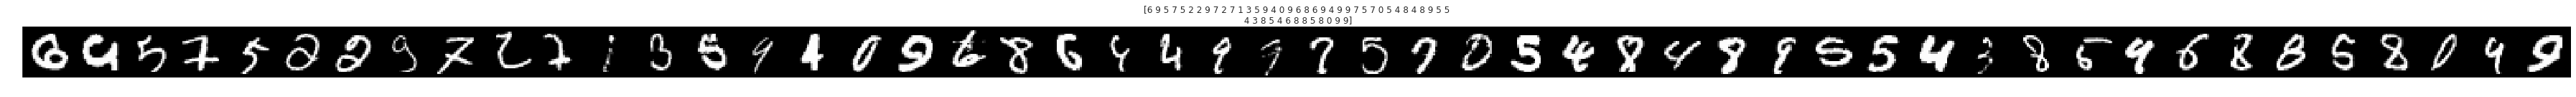

In [0]:
decision = tf.argmax(bnn_predicted_log_probs, axis=-1, output_type=tf.int32)
confidence = tf.reduce_max(bnn_predicted_log_probs, axis=-1)
threshold = 0.95

decided_idx = tf.where(confidence > np.log(threshold))
ordered = tf.argsort(confidence)

n = datasets_info.splits['test'].num_examples
x_final, y_final = next(iter(eval_dataset.batch(n)))

print('Number of examples undecided: {}'.format(n - tf.size(decided_idx)))

accurary = tf.reduce_mean(
    tf.cast(tf.equal(tf.gather(y_final, decided_idx),
                     tf.gather(decision, decided_idx)),
            tf.float32))
print('Accurary after excluding undecided ones: {}'.format(accurary))

tfn.util.display_imgs(
     tf.gather(x_final, ordered[0:50]),
     tf.gather(y_final, ordered[0:50]));

In [0]:
from sklearn import metrics
bnn_auc = np.array([
  metrics.roc_auc_score(tf.equal(y_final, i), bnn_predicted_log_probs[:, i])
  for i in range(10)])
print('Per class AUC:\n{}'.format(bnn_auc[:, np.newaxis]))

Per class AUC:
[[0.99994366]
 [0.99992725]
 [0.99974284]
 [0.99959576]
 [0.99985348]
 [0.99967074]
 [0.99962562]
 [0.99963218]
 [0.99862774]
 [0.99943871]]


### 6 Appendix: Compare against DNN

In [0]:
max_pool = tf.keras.layers.MaxPooling2D(  # Has no tf.Variables.
    pool_size=(2, 2),
    strides=(2, 2),
    padding='SAME',
    data_format='channels_last')

dnn = tfn.Sequential([
  tfn.Convolution(
      input_size=1,
      output_size=8,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      name='conv1'),
  tf.nn.leaky_relu,
  max_pool,  # [28, 28, 8] -> [14, 14, 8]
  tfn.Convolution(
      input_size=8,
      output_size=16,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      name='conv2'),
  tf.nn.leaky_relu,
  max_pool,  # [14, 14, 16] -> [7, 7, 16]
  tfn.util.flatten_rightmost(ndims=3),
  tfn.Affine(
      input_size=7 * 7 * 16,
      output_size=10,
      name='affine1'),
  lambda x: tfd.Categorical(logits=x, dtype=tf.int32),   
], name='DNN')

print(dnn.summary())

=== DNN ==================================================
  SIZE SHAPE                TRAIN NAME                                    
     8 [8]                  True  bias:0                                  
   200 [5, 5, 1, 8]         True  kernel:0                                
    16 [16]                 True  bias:0                                  
  3200 [5, 5, 8, 16]        True  kernel:0                                
    10 [10]                 True  bias:0                                  
  7840 [784, 10]            True  kernel:0                                
trainable size: 11274  /  0.043 MiB  /  {float32: 11274}


In [0]:
train_iter = iter(train_dataset)
eval_iter = iter(eval_dataset.batch(2000).repeat())

def loss():
  x, y = next(train_iter)
  return -tf.reduce_mean(dnn(x).log_prob(y), axis=-1), None

opt = tf.optimizers.Adam(learning_rate=1e-2)
 
fit = tfn.util.make_fit_op(
    loss,
    opt,
    dnn.trainable_variables,
    grad_summary_fn=lambda gs: tf.nest.map_structure(tf.norm, gs))

@tf.function(autograph=False)
def eval():
  with tf.xla.experimental.jit_scope(compile_ops=True):
    x, y = next(eval_iter)
    yhat = dnn(x)
    nll = -tf.reduce_mean(yhat.log_prob(y), axis=-1)
    acc = tf.reduce_mean(tf.cast(tf.equal(y, yhat.mode()), tf.float32), axis=-1)
    return nll, acc

In [0]:
num_train_steps = 20e3  # @param { isTemplate: true}
num_train_steps = int(num_train_steps)  # Enforce correct type when overridden.
dur_sec = dur_num = 0

for i in range(num_train_steps):
  start = time.time()
  trn_loss, _, g = fit()
  stop = time.time()
  dur_sec += stop - start
  dur_num += 1
  if i % 100 == 0 or i == num_train_steps - 1:
    tst_loss, tst_acc= eval()
    f, x = zip(*[
        ('it:{:5}', opt.iterations),
        ('ms/it:{:6.4f}', dur_sec / max(1., dur_num) * 1000.),
        ('tst_acc:{:6.4f}', tst_acc),
        ('trn_loss:{:6.4f}', trn_loss),
        ('tst_loss:{:6.4f}', tst_loss),
        ('tst_nll:{:6.4f}', tst_nll),
        ('tst_kl:{:6.4f}', tst_kl),
        ('sum_norm_grad:{:6.4f}', sum(g)),

    ])
    print('   '.join(f).format(*[getattr(x_, 'numpy', lambda: x_)()
                                 for x_ in x]))
    sys.stdout.flush()
    dur_sec = dur_num = 0
  # if i % 1000 == 0 or i == maxiter - 1:
  #   dnn.save('/tmp/vae.npz')

it:    1   ms/it:947.1798   tst_acc:0.2020   trn_loss:2.4360   tst_loss:2.2867   tst_nll:0.1681   tst_kl:0.2860   sum_norm_grad:2.2128
it:  101   ms/it:1.8313   tst_acc:0.9485   trn_loss:0.0494   tst_loss:0.1961   tst_nll:0.1681   tst_kl:0.2860   sum_norm_grad:1.5276
it:  201   ms/it:1.8815   tst_acc:0.9515   trn_loss:0.0971   tst_loss:0.1553   tst_nll:0.1681   tst_kl:0.2860   sum_norm_grad:1.6970
it:  301   ms/it:1.8873   tst_acc:0.9595   trn_loss:0.0675   tst_loss:0.1329   tst_nll:0.1681   tst_kl:0.2860   sum_norm_grad:1.6763
it:  401   ms/it:1.9162   tst_acc:0.9590   trn_loss:0.0372   tst_loss:0.1261   tst_nll:0.1681   tst_kl:0.2860   sum_norm_grad:1.1034
it:  501   ms/it:1.8792   tst_acc:0.9565   trn_loss:0.2008   tst_loss:0.1358   tst_nll:0.1681   tst_kl:0.2860   sum_norm_grad:1.5304
it:  601   ms/it:1.8019   tst_acc:0.9670   trn_loss:0.1382   tst_loss:0.0962   tst_nll:0.1681   tst_kl:0.2860   sum_norm_grad:2.8372
it:  701   ms/it:1.8842   tst_acc:0.9595   trn_loss:0.1764   tst_lo

In [0]:
@tf.function(autograph=False)
def dnn_predicted_log_prob(x):
  with tf.xla.experimental.jit_scope(compile_ops=True):
    return tf.math.log_softmax(dnn(x).logits, axis=-1)
  
eval_iter = iter(eval_dataset.batch(2000))

dnn_predicted_log_probs = tf.reshape(
    tf.stack([dnn_predicted_log_prob(x) for x, _ in eval_iter], axis=0),
    shape=[datasets_info.splits['test'].num_examples, -1])

Number of examples undecided: 127
Accurary after excluding undecided ones: 0.98480707407


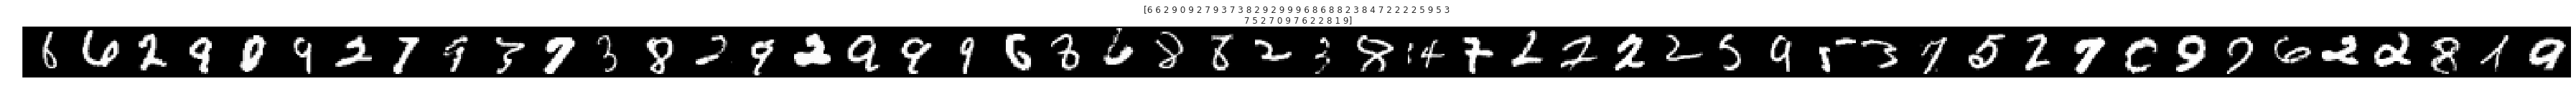

In [0]:
decision = tf.argmax(dnn_predicted_log_probs, axis=-1, output_type=tf.int32)
confidence = tf.reduce_max(dnn_predicted_log_probs, axis=-1)
threshold = 0.95

decided_idx = tf.where(confidence > np.log(threshold))
ordered = tf.argsort(confidence)

n = datasets_info.splits['test'].num_examples
x_final, y_final = next(iter(eval_dataset.batch(n)))

print('Number of examples undecided: {}'.format(n - tf.size(decided_idx)))

accurary = tf.reduce_mean(
    tf.cast(tf.equal(tf.gather(y_final, decided_idx),
                     tf.gather(decision, decided_idx)),
            tf.float32))
print('Accurary after excluding undecided ones: {}'.format(accurary))

tfn.util.display_imgs(
     tf.gather(x_final, ordered[0:50]),
     tf.gather(y_final, ordered[0:50]));

In [0]:
from sklearn import metrics
dnn_auc = np.array([
  metrics.roc_auc_score(tf.equal(y_final, i), dnn_predicted_log_probs[:, i])
  for i in range(10)])
print('Per class AUC:\n{}'.format(dnn_auc[:, np.newaxis]))

Per class AUC:
[[0.99905177]
 [0.99976495]
 [0.9995598 ]
 [0.99976883]
 [0.99948807]
 [0.99970995]
 [0.99963312]
 [0.99960009]
 [0.99943057]
 [0.99946715]]
